# Chapter 2 - Working with text data

## 2.2 Tokenizing text

The code below will pull the `requirements.txt` file in. Since I already have it, it is commented out.

In [1]:
# import urllib.request
# url = ("https://raw.githubusercontent.com/rasbt/"
#        "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
#        "the-verdict.txt")
# file_path = "the-verdict.txt"
# urllib.request.urlretrieve(url, file_path)

In [2]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [3]:
import re
text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [4]:
result = re.split(r'([,.]|\s)', text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [5]:
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [6]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [7]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4690


In [8]:
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


## 2.3 Converting tokens into token IDs

    "Next, let’s convert these tokens from a Python string to an integer representation to produce the token IDs. This conversion is an intermediate step before converting the token IDs into embedding vectors. To map the previously generated tokens into token IDs, we have to build a vocabulary first. This vocabulary defines how we map each unique word and special character to a unique integer:"

In [9]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

1130


In [10]:
vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


### Tokenizer class

Creating a tokenizer class from scratch to ensure it has basic capabilities:
1. Stores the vocabulary as a class attribute for access in the encode and decode methods
2. Creates an inverse vocabulary that maps token IDs back to the original text tokens
3. Processes input text into token IDs
4. Converts token IDs back into text
5. Removes spaces before the specified punctuation

In [11]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab            #1
        self.int_to_str = {i:s for s,i in vocab.items()}        #2

    def encode(self, text):         #3
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):         #4
        text = " ".join([self.int_to_str[i] for i in ids]) 

        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)    #5
        return text

In [12]:
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know," 
       Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [13]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


In [14]:
try:
    text = "Hello, do you like tea?"
    print(tokenizer.encode(text))
except:
    print("This will fail since Hello is not used in this short story")

This will fail since Hello is not used in this short story


## 2.4 Adding special context tokens

We need to add in unique tokens for unknown words and end-of-text separators

In [15]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}

print(len(vocab.items()))

1132


In [16]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [17]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        preprocessed = [item if item in self.str_to_int            #1
                        else "<|unk|>" for item in preprocessed]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])

        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)    #2
        return text

#1 Replaces unknown words by <|unk|> tokens
#2 Replaces spaces before the specified punctuations

In [18]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [19]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [20]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


## 2.5 Byte pair encoding

    "Let’s look at a more sophisticated tokenization scheme based on a concept called byte pair encoding (BPE). The BPE tokenizer was used to train LLMs such as GPT-2, GPT-3, and the original model used in ChatGPT. Since implementing BPE can be relatively complicated, we will use an existing Python open source library called [tiktoken](https://github.com/openai/tiktoken), which implements the BPE algorithm very efficiently based on source code in Rust."

Since it is already in my requirements file, I am not doing a special install here.

While this section does not implement BPE from scratch, he has [an optional repo for this on his original repo here](https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/05_bpe-from-scratch/bpe-from-scratch.ipynb)

In [21]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.9.0


In [22]:
tokenizer = tiktoken.get_encoding("gpt2")

In [23]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [24]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


Note that `allowed_special` helped us include the `"<|endoftext|>"` token and expand the vocabulary automatically. That is why it has the largest token ID (50256).

Quoting the author directly:

    "The algorithm underlying BPE breaks down words that aren’t in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words. So, thanks to the BPE algorithm, if the tokenizer encounters an unfamiliar word during tokenization, it can represent it as a sequence of subword tokens or characters, as illustrated in figure 2.11."
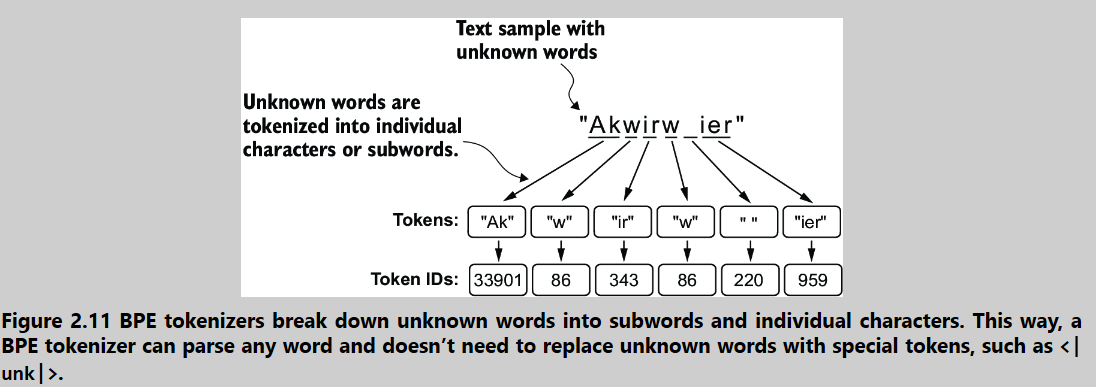

### Exercise 2.1 Byte pair encoding of unknown words  
    
    "Try the BPE tokenizer from the tiktoken library on the unknown words “Akwirw ier” and print the individual token IDs. Then, call the decode function on each of the resulting integers in this list to reproduce the mapping shown in figure 2.11. Lastly, call the decode method on the token IDs to check whether it can reconstruct the original input, “Akwirw ier.”
    

In [25]:
ex = "Akwirw ier"
integers = tokenizer.encode(ex)
print(integers)

[33901, 86, 343, 86, 220, 959]


In [26]:
for i in integers:
    print(tokenizer.decode([i]))

Ak
w
ir
w
 
ier


In [27]:
strings = tokenizer.decode(integers)
print(strings)

Akwirw ier


## 2.6 Data sampling with a sliding window

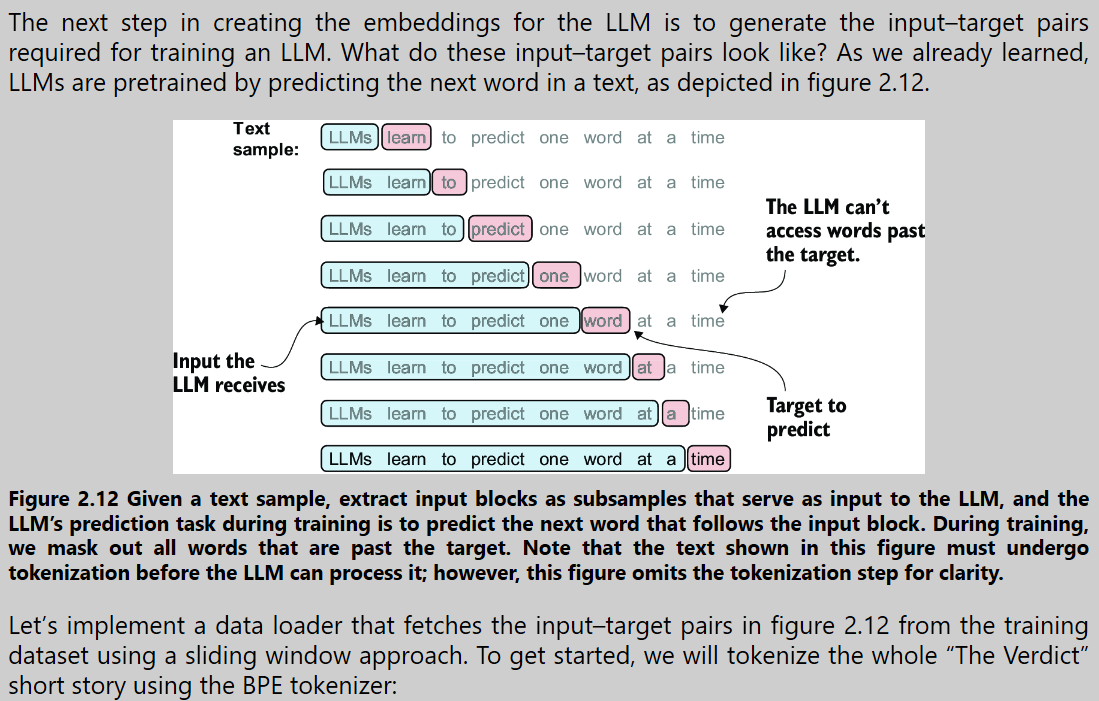

In [28]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [29]:
enc_sample = enc_text[50:]
print(enc_sample[:5])

[290, 4920, 2241, 287, 257]


In [30]:
context_size = 4         #1. The context size determines how many tokens are included in the input.
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [31]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [32]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


### Sidenote: Using CUDA for Torch

I am doing all of this on a laptop with a 4090 GPU so want to ensure I can take advantage of CUDA acceleration. Which seems to be the case given what I see below:

In [33]:
import torch
torch.cuda.is_available()

True

In [34]:
#1 Tokenizes the entire text
#2 Uses a sliding window to chunk the book into overlapping sequences of max_length
#3 Returns the total number of rows in the dataset
#4 Returns a single row from the dataset
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)    #1

        for i in range(0, len(token_ids) - max_length, stride):     #2
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):    #3
        return len(self.input_ids)

    def __getitem__(self, idx):         #4
        return self.input_ids[idx], self.target_ids[idx]

In [35]:
#1 Initializes the tokenizer
#2 Creates dataset
#3 drop_last=True drops the last batch if it is shorter than the specified batch_size to prevent loss spikes during training.
#4 The number of CPU processes to use for preprocessing

def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")                         #1
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)   #2
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,     #3
        num_workers=num_workers     #4
    )

    return dataloader

In [36]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader)      #1 Converts dataloader into a Python iterator to fetch the next entry via Python’s built-in next() function
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [37]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


### Exercise 2.2 Data loaders with different strides and context sizes 
    
    To develop more intuition for how the data loader works, try to run it with different settings such as max_length=2 and stride=2, and max_length=8 and stride=2.

In [38]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=2, stride=2, shuffle=False)
data_iter = iter(dataloader)      #1 Converts dataloader into a Python iterator to fetch the next entry via Python’s built-in next() function
first_batch = next(data_iter)
print(first_batch)

[tensor([[ 40, 367]]), tensor([[ 367, 2885]])]


In [39]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[2885, 1464]]), tensor([[1464, 1807]])]


In [40]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=8, stride=2, shuffle=False)
data_iter = iter(dataloader)      #1 Converts dataloader into a Python iterator to fetch the next entry via Python’s built-in next() function
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464, 1807, 3619,  402,  271]]), tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899]])]


In [41]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 2885,  1464,  1807,  3619,   402,   271, 10899,  2138]]), tensor([[ 1464,  1807,  3619,   402,   271, 10899,  2138,   257]])]


In [42]:
# Note that we increase the stride to 4 to utilize the data set fully (we don’t skip a single word). 
# This avoids any overlap between the batches since more overlap could lead to increased overfitting.

dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=4, stride=4,
    shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## 2.7 Creating token embeddings

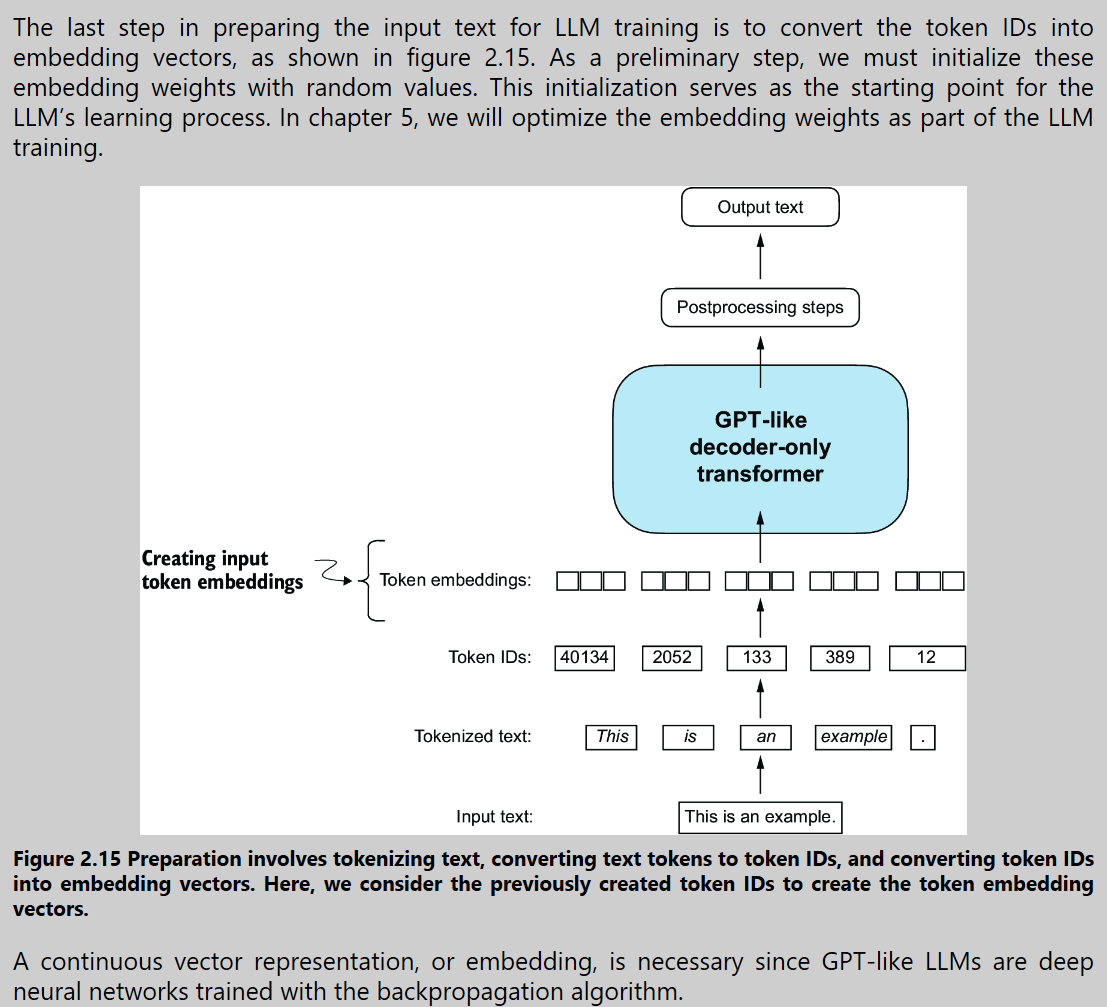

In [43]:
input_ids = torch.tensor([2, 3, 5, 1])

In [44]:
vocab_size = 6
output_dim = 3

In [45]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [46]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [47]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


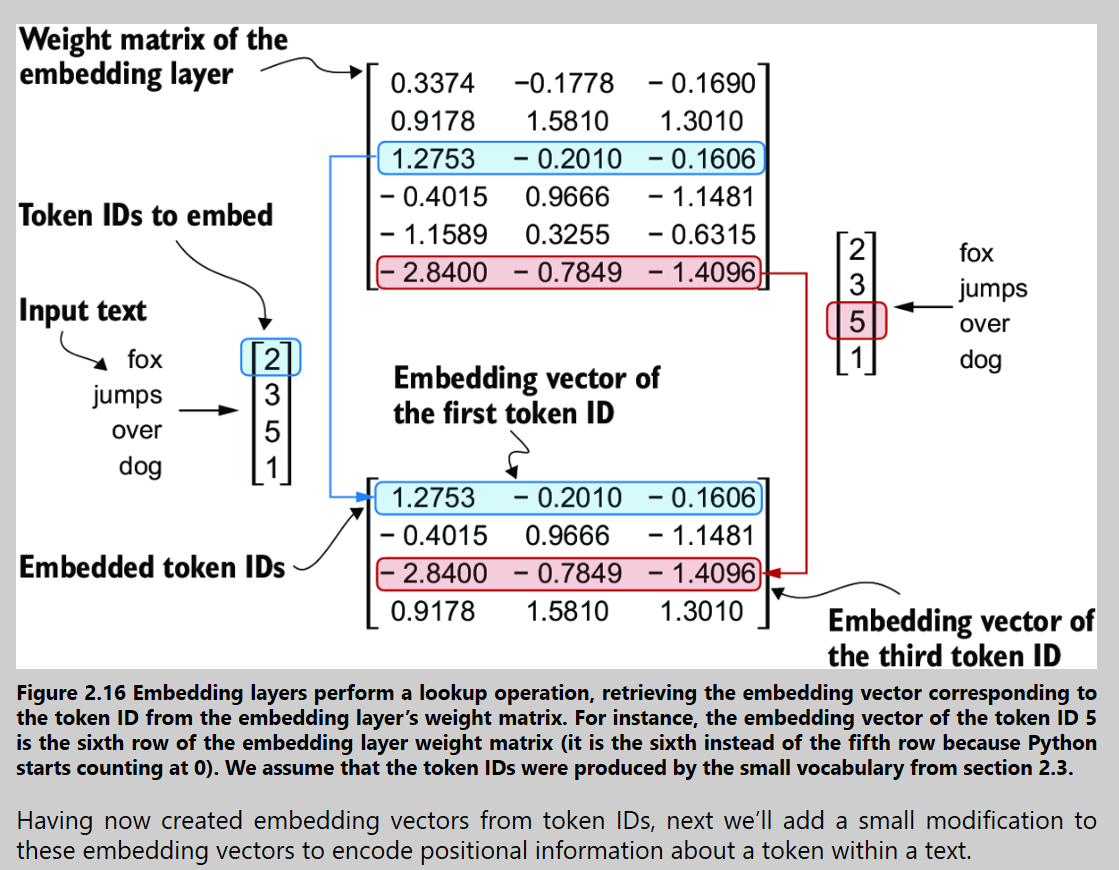

## 2.8 Encoding word positions

In [48]:
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [49]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
   stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [50]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [51]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [52]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])
